Joint thesis project of University of Bonn and Politecnico di Milano




Thesis title: 

**Global Sea Level Rise and Coastal Vulnerability Assessed via Inundation Maps**





Program:

**Master of Geoinformatics Engineering***


Topic of the report:

**Future Inundation Map and Coastal Volnurability in Germany and Netherlands Coastal Area**




Author: 

**Sahar Gholami Bourani**



Supervisors:

**Prof. Maria Brovelli**

**Prof. Jurgen Kusche**




Thanks to:

**Dr. Bernd Uebbing**

**Juan Pablo Duque Ordoñez**

Date: 22 August 2023

# Future Inundation Map and Coastal Volnurability in Germany and Netherlands Coastal Area
In order to evaluate coastal vulnurability caused by **Sea Level Rise** during 21th century, future flood maps for the study area are produced. For future flood simulaton we assume that the coastal lands whose elevations are lower than future sea level height will be flooded. Therefore, we need to compare the **Digital Elevation Model** and **future sea level height**. So, at the first step we need to simulate the future sea level height. To do so, a base sea level is considered and the sea level **change** is projected using observed anual sea level rise **trend**. Hence, the datasets which build the flood models include:
- **Mean Sea Level Surface 1995-2014**
- **Sea Level Projection for the year 2020** 
- **Annual sea level rise Trend between 1-2005  to 12-2015**
- **Geoid**
- **Bedrock**

The first three datasets are used to simulate future sea level height and the last two datasets define the digital evelation model. 

Here, the volnurability of the coastal area in Germany and Netherlands is assessed.


# Sea Level Change Projection for the year 2020

**Sea level change projections** dataset is associated with Working Group 1 (WG1) of the Sixth Assessment Report (AR6) of Intergovernmental Panel on Climate Change (**IPCC**). https://www.ipcc.ch/report/ar6/wg1/ These projections are performed with respect to the baseline of 1995 to 2014 and for each 10-year future epochs from 2020 to 2150. Therefore, for computing sea level height 2020, we need to add later this sea level change to the mean sea surface over the period 1995 to 2014. 
The IPCC Working Group I contribution (the Physical Science Basis team) was released on 9 August 2021. Chapter 9 of the report assesses past and projected changes in the ocean, cryosphere and sea level using paleoreconstructions, instrumental observations and model simulations. https://www.ipcc.ch/report/ar6/wg1/chapter/chapter-9/ 
In section 9.6 the sea level change is discussed in Global and Regional scale and in pre-satelite and satelite era. Since this research aims to take the regional variability into account, the relative sea level projections dataset is employed as sea level change of future epochs (under ar6-regional-confidence.zip) https://zenodo.org/record/5914710 . The dataset is based on updated simulations obtained from the Coupled Model Intercomparison Project Phase 6 (CMIP6) ensemble. These simulations enable the projection of ocean dynamic sea level contributions to regional sea level change. Data of regional analysis are available in low confidence an medium confidence which refer to the level of uncertainity in the projections. Here we focus on medium confidence. Regional sea level can differ from the global mean sea level change due to various factors such as vertical land movement, ice mass changes, and ocean dynamical changes. For each of 5 climate change scenarios, different levels of sea level change are projected. 
Here, we consider **scenario SSP2-4.5** that corresponds to the **middle of the road**. In this scenario CO2 emissions hover around current levels before starting to fall mid-century, but do not reach net-zero by 2100. Socioeconomic factors follow their historic trends, with no notable shifts. Progress toward sustainability is slow, with development and income growing unevenly. In this scenario, temperatures rise **2.7°C** by the end of the century.

The impacts of all contributors of sea level change are studied individually and totally in different datasets. These contributors include: **thermal expansion, Greenland and Antarctic ice sheet contributions, glacier melt, vertical land motion and land-water storage**. Since no single model can directly compute all these contributions, they are calculated individually and subsequently combined. Thus, the dataset used for this research encompasses the **total combination** of all drivers. 


In [1]:
#necessary packages
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import matplotlib as m
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cmocean #colormap for oceanography https://matplotlib.org/cmocean/
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon, Point
from osgeo import gdal, ogr
import subprocess
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%matplotlib widget

## The IPCC sea level change dataset overview
The IPCC sea level change projection dataset for regional medium confidence is a collection of netcdf files. For each scenario there are 6x2 files (sea level change value and rate for each contributor) and 1x2 (value and rate)for the total combination of the contributors. Here we consider the values of the total combination dataset for the scanario ssp245.

In [3]:
#directory of the data for the two scenarios ssp245 
ssp245_dir = '/home/sahar/SLR_Bonn_Polimi/Data/IPCC/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/ssp245/total_ssp245_medium_confidence_values.nc'
#open netcdf files
SLC_IPCC_ssp245 = xr.open_dataset(ssp245_dir)


Dataset for ssp245:

In [4]:
SLC_IPCC_ssp245

<xarray.Dataset>
Dimensions:           (locations: 66190, quantiles: 107, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
  * quantiles         (quantiles) float64 0.0 0.001 0.005 ... 0.995 0.999 1.0
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (quantiles, years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:50:23 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...

The dataset has geographical coordinate system with 10-year temporal resolution and temporal coverage from 2020 to 2150. It contains **1030 Tide Guage** (non-grid) data points and **65190 altimetry grid points**. Geographical resolution of altimetry dataset is **1 Degree** East longitude  1 Degree North latitude and the geograhical coverage is the whole earth (-180, -90, 180, 90).
The coordinates and dimensions of the dataset are years, locations and quantiles.

The **years**, include 14 time epochs from 2020 to 2150.

The **locations** coordinate, is a unique id for each lat-lon point of data (66190 locations that contain 65160 altimetry and 1030 tide guage data points).

The **quantile** refers to the likelihood and is a value between 0 to 1.

The variables of the dataset are latitude, longitude and sea level change. 


## Data Preprocessing

To narrow down the complexity of uncertainity of the dataset we focus on **quntile=0.5** as median.
For this test two years of 2020 and 2050 are considered.
Also just altimetry data is intended. So, the tide guage data (with non-grid latitude or longitude will be dropped from the process).
In order to make the dataset compatable for the GIS environment and geospatial tools we need to have the latitude and longitude in the dimensions. Therefore, the data are interpolated with nearest method. The result are Geotiff maps that are readable in GIS software. 

### Extracting 50% quantiles

In [5]:
#select the median (50% probability)
SLC_median_ssp245 = SLC_IPCC_ssp245.sel(quantiles=0.50, method='nearest')
#drop quantiles from the the data
SLC_median_ssp245 = SLC_median_ssp245.drop_vars('quantiles') 
print(f'dataset for the scenario ssp245 {SLC_median_ssp245}')

dataset for the scenario ssp245 <xarray.Dataset>
Dimensions:           (locations: 66190, years: 14)
Coordinates:
  * years             (years) int32 2020 2030 2040 2050 ... 2120 2130 2140 2150
  * locations         (locations) int32 1 2 3 ... 1018003580 1018003590
Data variables:
    lat               (locations) float32 ...
    lon               (locations) float32 ...
    sea_level_change  (years, locations) float32 ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 13:50:23 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes/pb_1f/ss...


### Selecting altimetry data
In order to extract altimetry data from the original dataset, the grid data which have integer latitude and longitude will be considered.

In [6]:
#extract grid (altimetry data)
SLC_median_ssp245 = SLC_median_ssp245.sel(locations=(SLC_median_ssp245.lat % 1 == 0) & (SLC_median_ssp245.lon % 1 == 0))


### Interpolation of IPCC Sea Level Change- Altimetry data
The Interpolation for the year 2020 of the scenario ssp245 is carried out for altimetry data with original geographical resolution of the dataset, which is 1 degree resolution. The process has been performed with **Scipy-interpolation** library and the result is saved as a **Geotiff** file with **rasterio** package with the coordinate refernce of original data which is 4326 (**WGS48**) and plotted with **Cartopy** package.

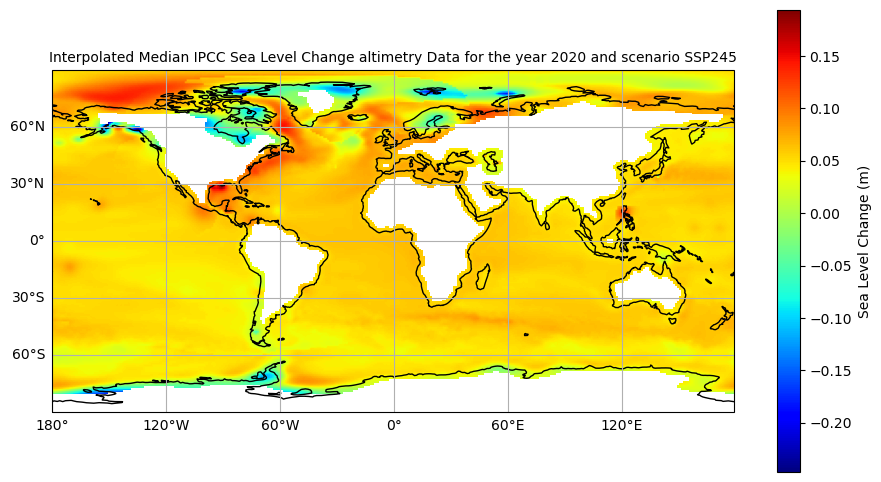

In [7]:
#output directory
tif_2020 = '/home/sahar/SLR_Bonn_Polimi/output_tif/IPCC_SLC_2020_SSP245.tif'
 
#extract sea level change
sea_level_2020 = SLC_median_ssp245['sea_level_change'].sel(years=2020)

#inputs of the interpolation
lat = SLC_median_ssp245['lat'].values
lon = SLC_median_ssp245['lon'].values
sea_level_values_2020 = sea_level_2020.values.flatten() / 1000  # Convert mm to m

#create a lat-lon grid with original resolution
lat_grid = np.arange(np.max(lat), np.min(lat) -1, -1)
lon_grid = np.arange(np.min(lon), np.max(lon) + 1, 1)

#generate grid
xi_lon_grid, xi_lat_grid = np.meshgrid(lon_grid, np.flip(lat_grid))
xi_points = np.column_stack((xi_lat_grid.ravel(), xi_lon_grid.ravel()))  # To put grid-lat, grid_lon_1d in one 2d array
points = np.column_stack((lat, lon))  # To put original lat lon in one 2d array
    
#pertrform interpolation of SLC on xi_points based on nearest neighbor method
interpolated_sea_level_change_nearest_2020 = griddata(points, sea_level_values_2020, xi_points, method='nearest')

#reshape the interpolated arrays to match the grid shape
interpolated_sea_level_change_nearest_2020 = np.reshape(interpolated_sea_level_change_nearest_2020, xi_lon_grid.shape)
    
height, width = interpolated_sea_level_change_nearest_2020.shape #get the dimensions of the interpolated sea level change array
# define the affine transformation matrix for the geotiff
# the origin is set to the minimum longitude and maximum latitude
#the pixel size is set to the resolution of the latitude and longitude arrays
transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])

with rasterio.open(tif_2020, 'w', driver='GTiff', height=height, width=width, count=1, dtype=interpolated_sea_level_change_nearest_2020.dtype, crs='EPSG:4326', transform=transform) as dst:
    dst.write(interpolated_sea_level_change_nearest_2020, 1)

    #the pixel size is set to the resolution of the latitude and longitude arrays
    transform = from_origin(np.min(lon_grid), np.min(lat_grid), lon_grid[1] - lon_grid[0], lat_grid[1] - lat_grid[0])

#flip the interpolated arrays vertically
interpolated_sea_level_change_nearest_2020 = np.flipud(interpolated_sea_level_change_nearest_2020)

    
#plot the interpolation
plt.figure(figsize=(11, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.imshow(interpolated_sea_level_change_nearest_2020, extent=[np.min(lon_grid), np.max(lon_grid), np.min(lat_grid), np.max(lat_grid)], cmap='jet')
plt.colorbar(im, label='Sea Level Change (m)')
ax.set_title(f'Interpolated Median IPCC Sea Level Change altimetry Data for the year 2020 and scenario SSP245', fontsize= 10)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False


## Sea Level Change in 2020 in the Bounding Box
In order to produce future flood maps for the study area- here German and Netherlands costal area- first bounding box of the study area is created, Then the future sea level change for the bounding box is masked from the global interpolated maps of IPCC sea level change.

### Creating Europe bounding Box
The bounding box of the study area is created as a shapefile using **geopandas** and **Shapely** packages.

In [8]:
#bounding box coordinates
bbox = (3, 50, 15, 55) 
#creating polygon using shapely
polygon = Polygon([(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])])
#making a geodataframe with the polygon
gdf = gpd.GeoDataFrame(geometry=[polygon])
#set the coordinate to wgs84
gdf.crs = "EPSG:4326"
#output shapefile path
area_bbox = "/home/sahar/SLR_Bonn_Polimi/output_shp/Europe_bbox.shp"
#save as shapefile
gdf.to_file(area_bbox)


### Masking the 2020 Sea Level Change for the study area
Using **Warp** function of **GDAL** library, the IPCC projected global sea level change map has been masked with the shapefile of the bounding box. The result is saved as a Geotiff file. 

In [9]:
#open downloded Global SLC in gdal
ds = gdal.Open('/home/sahar/SLR_Bonn_Polimi/output_tif/IPCC_SLC_2020_SSP245.tif')
#output direcory
EU_IPCC_SLC_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/EU_IPCC_SLC_2020_SSP245.tif'
#clip for bbox
dsClip = gdal.Warp(EU_IPCC_SLC_path, ds, cutlineDSName= area_bbox, cropToCutline = True,
                  dstNodata = np.nan)
#define array
array = dsClip.GetRasterBand(1).ReadAsArray()
#close the created shp
ds_Clip = None

## Visualizing the clipped Sea Level Change for the study area
We visualize here the plotted map using **rasterio** and **Cartopy** packages.

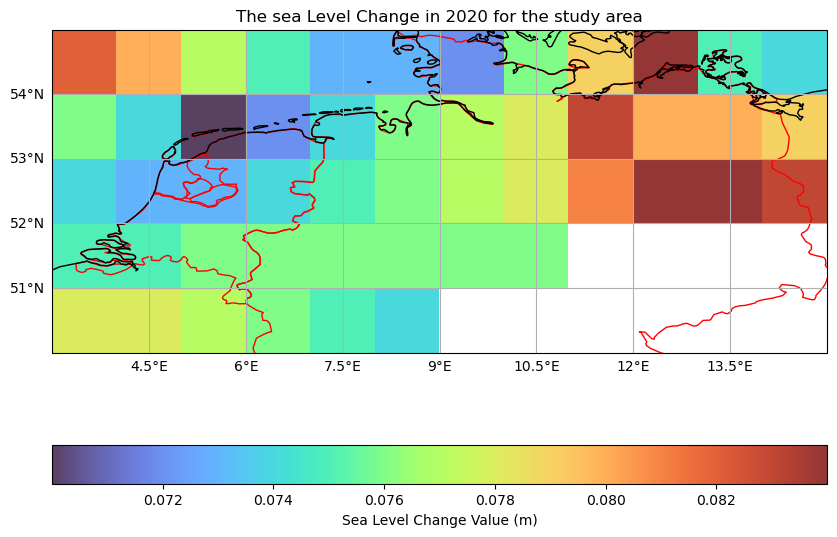

In [10]:
#read EU_IPCC_SLC
with rasterio.open(EU_IPCC_SLC_path) as src:
    # Read the EU_IPCC_SLC data as a numpy array
    EU_IPCC_SLC_array = src.read(1)

#get the extent of the EU_IPCC_SLC
with rasterio.open(EU_IPCC_SLC_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

# the shapefile of the administrative boundries of the area is downloaded from : https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/
area_adm_path = "/home/sahar/SLR_Bonn_Polimi/Data/countri_boundries/Ger_Net.shp" 
shapefile = gpd.read_file(area_adm_path)

#create geodataframe out of the shapefile of boundries
gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])

#plot
projection = ccrs.PlateCarree() #define projection
fig = plt.figure(figsize=(10, 8)) #figure size
ax = fig.add_subplot(111, projection=projection)
#Add the area-adm to the plot
ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
ax.coastlines() #add coastal lines to the plot

#plot EU_IPCC_SLC
cax = ax.imshow(EU_IPCC_SLC_array, cmap='turbo', extent=[xmin, xmax, ymin, ymax], alpha=0.8)
plt.colorbar(cax, label='Sea Level Change Value (m)', orientation='horizontal')
plt.title('The sea Level Change in 2020 for the study area')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

The black line is the shoreline and administative boundries of Germany and Netherlands are shown in red line.

# Annual Sea Level Rise Trend between 2005-01  to 2015-12

The annual sea level rise map for 2005-01 till 2015-12 is derived from a global fingerprint inversion technique (Rietbroek et al., 2016; Uebbing et al., 2019; Uebbing 2022). It depicts the change in sea level caused by diffrent contributors including Antractic, Greenland, Glaciers, hydrology and steric parameters individually and the total combination of all contributors. For the future flood simulation , the total combination of all contributors is considered. The total trend map is a netcdf file of the annual rate with unit of meters per year. 
Following the information regarding to the trend dataset is queried by Gdal and xarray libraries.


In [11]:
#get information of the dataset using gdalinfo
!gdalinfo /home/sahar/SLR_Bonn_Polimi/Data/Trend/trendMap_rsl_2005-01_2015-12_total.nc

Driver: netCDF/Network Common Data Format
Files: /home/sahar/SLR_Bonn_Polimi/Data/Trend/trendMap_rsl_2005-01_2015-12_total.nc
       /home/sahar/SLR_Bonn_Polimi/Data/Trend/trendMap_rsl_2005-01_2015-12_total.nc.aux.xml
Size is 1441, 721
Origin = (-180.125000000000000,90.125000000000000)
Pixel Size = (0.250000000000000,-0.250000000000000)
Metadata:
  lat#units=deg
  lon#units=deg
  tr_total#units=m/yr
Corner Coordinates:
Upper Left  (-180.1250000,  90.1250000) 
Lower Left  (-180.1250000, -90.1250000) 
Upper Right ( 180.1250000,  90.1250000) 
Lower Right ( 180.1250000, -90.1250000) 
Center      (   0.0000000,   0.0000000) 
Band 1 Block=1441x1 Type=Float64, ColorInterp=Undefined
  Min=-0.015 Max=0.024 
  Minimum=-0.015, Maximum=0.024, Mean=0.004, StdDev=0.004
  NoData Value=9.969209968386869e+36
  Unit Type: m/yr
  Metadata:
    NETCDF_VARNAME=tr_total
    STATISTICS_MAXIMUM=0.024426646864984
    STATISTICS_MEAN=0.0040561601874062
    STATISTICS_MINIMUM=-0.015118911385261
    STATISTICS_ST

In [4]:
xr.open_dataset('/home/sahar/SLR_Bonn_Polimi/Data/Trend/trendMap_rsl_2005-01_2015-12_total.nc')

<xarray.Dataset>
Dimensions:   (time: 1, lon: 1441, lat: 721)
Coordinates:
  * time      (time) float64 0.0
  * lon       (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * lat       (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Data variables:
    tr_total  (lat, lon) float64 ...

The dataset has geographical coordinate and contains **1038961** data points. Geographical resolution of the dataset is **0.25 Degree** East longitude  0.25 Degree North latitude and the geograhical coverage is the whole earth (-180, -90, 180, 90).
The coordinates and dimensions of the dataset are time, lon and lat.

The **time** is a fixed coordinate since the dataset shows the annual trend.

The **lon** is the longitude coordinate which contains 1441 points from -180 to 180 degree east.

The **lat** is the latitude coordinate which contains 721 data points from -90 to 90 degree north.

The dataset has only one variable which is  **"tr_total"** corresponding to the total trend combination of the contributors. The unit of the trend is meter per year **(m/y)**.

## Visualizing the sea level change trend
Following the mean sea level change during 2005-01 to 2015-12 is visualized globally.

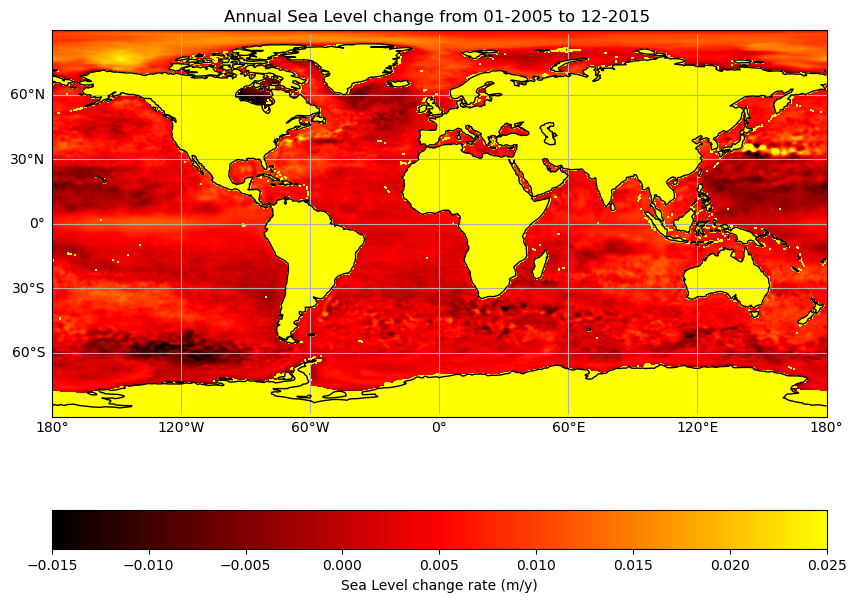

In [12]:
#read your data from the raster file
trnd = "/home/sahar/SLR_Bonn_Polimi/Data/Trend/trendMap_rsl_2005-01_2015-12_total.nc"
with rasterio.open(trnd) as src:
    array = src.read(1)

#get the extent
with rasterio.open(trnd) as src:
    xmin, ymin, xmax, ymax = src.bounds
#https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib
#define the custom colormap
cdict = {
    'red': ((0.0, 0.0, 0.0), (0.5, 1.0, 1.0), (1.0, 1.0, 1.0)),
    'green': ((0.0, 0.0, 0.0), (0.5, 0.0, 0.0), (1.0, 1.0, 1.0)),
    'blue': ((0.0, 0.0, 0.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0))
}

custom_cmap = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

#plot using the custom colormap
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.coastlines(zorder=10)

#set the desired range for the colorbar
vmin = -0.015
vmax = 0.025
cax = ax.imshow(array, cmap=custom_cmap, extent=[xmin, xmax, ymin, ymax], vmin=vmin, vmax=vmax)
plt.colorbar(cax, label='Sea Level change rate (m/y)', orientation='horizontal')
plt.title('Annual Sea Level change from 01-2005 to 12-2015 ')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()


## Extrapolation the Sea to the Land

The sea level change trend map illustrates the mean sea level change between 2005-2015. While sea level rise will change the aquatic expanse as the result of interfering the sea to the land and modifies the coastal terrains. Therefore, assessing the future volnurability of coastal areas and simulating future floods, necessitates the extension of sea surface projections onto the terrestrial domain. To do so, the sea surface is extrapolated for the study area bounding box.  

## Converting the trend to point shapefile

In order to do the extrapolation (interpolation the sea surface beyond its current extent), the data points are interpolated. So in first step, we need to extract the data as point shapefile. It is performed by **Shapely** library.

In [13]:
#read the netcf file with xarray
SLR_trend_tot = xr.open_dataset(trnd) 
SL_pnt = '/home/sahar/SLR_Bonn_Polimi/output_shp/SLC_trend.shp' #directory of the output point shapefile 
#read the lon/lat as a list
lons = SLR_trend_tot['lon'].values
lats = SLR_trend_tot['lat'].values
#reda the SLR as a list
SL_trend = SLR_trend_tot['tr_total'].values.flatten()
#create meshgrid of lat/lon
lon_grid, lat_grid = np.meshgrid(lons, lats)

#flatten the lon_grid and lat_grid arrays to get all the points
points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
data = {'SL_trend': SL_trend} #field name
gdf = gpd.GeoDataFrame(data, geometry=[Point(xy) for xy in points], crs="EPSG:4326") #making geo data frame
#save the gdf as a shapefile
gdf.to_file(SL_pnt, driver='ESRI Shapefile')

## Extrapolation the sea to the land

In the next step, the point shapefile is interpolated for the case study bounding box by Inverse Distance Weight (IDW) algorithm with **Gdal** library.

In [14]:
# Extrapolating the trend of sea level change for the the whole bbox
#output interpolated raster directory
EU_trend = "/home/sahar/SLR_Bonn_Polimi/output_tif/EU_trend.tif"
#reading the netcdf file with gdal
trnd_nc = gdal.Open(trnd)
#reading the vetor shapefile with ogr
trnd_shp = ogr.Open(SL_pnt, 0)
#get the layer of the shapefile
layer = trnd_shp.GetLayer()
#get the geotransform parameters from the netcdf file
gt = trnd_nc.GetGeoTransform()
#get resolution from the geotransformation
res = gt[1]
#output pixel size
xsize = (bbox[2]- bbox[0])/res
ysize = (bbox[3]- bbox[1])/res
#checking th field name
for field in layer.schema:
    print(field.name)
#closing the opend gdal
trnd_shp = trnd_nc = layer = None
#performing the idw interpolation for bbox extension
idw = gdal.Grid(EU_trend, SL_pnt, zfield="SL_trend",
                algorithm = "invdist", outputBounds = (bbox[0], bbox[3], bbox[2], bbox[1]),
               width = xsize, height = ysize)
#closing the tif file
idw = None


SL_trend


# Visualizing the extraterpolated annual sea level trend for study area

Now that the annual sea level change is interpolated for the whole bounding box, we will see the result as a tif file.

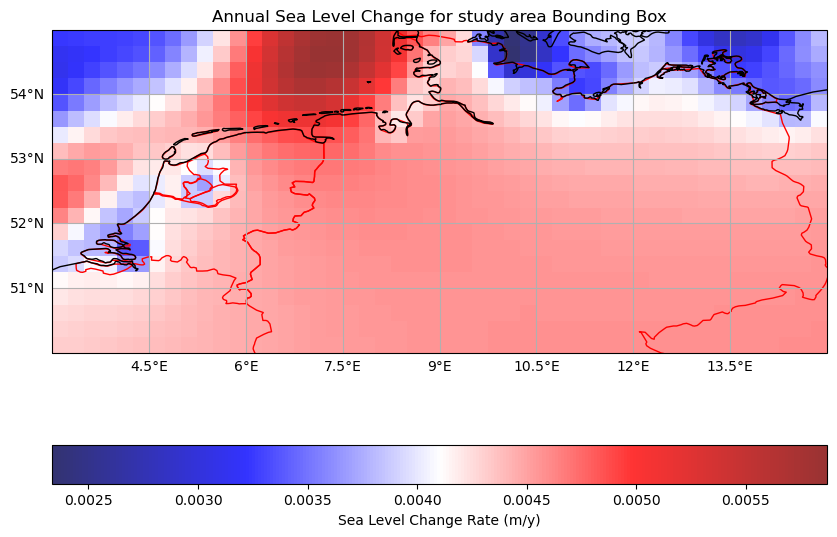

In [15]:
#read EU_trend
with rasterio.open(EU_trend) as src:
    # Read the EU_trend data as a numpy array
    EU_trend_array = src.read(1)

#get the extent of the EU_trend
with rasterio.open(EU_trend) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.coastlines(zorder= 10)
#area_adm_path = "/home/sahar/SLR_Bonn_Polimi/Data/countri_boundries/Ger_Net.shp" 
shapefile = gpd.read_file(area_adm_path)
#create geodataframe out of the shapefile of boundries
gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])
#Add the area-adm to the plot
ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
#plot EU_trend
cax = ax.imshow(EU_trend_array, cmap='seismic', extent=[xmin, xmax, ymin, ymax], alpha=0.8,)
plt.colorbar(cax, label='Sea Level Change Rate (m/y)', orientation='horizontal')
plt.title('Annual Sea Level Change for study area Bounding Box')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Geoid Dataset
The geoid is a model of global mean sea level that is used to measure precise surface elevations. The radius at the equator is larger than at the poles due to the long-term effects of the earth's rotation. And, at a smaller scale, there is topography—mountains have more mass than a valley and thus the pull of gravity is regionally stronger near mountains. All of these large and small variations to the size, shape, and mass distribution of the earth cause slight variations in the acceleration of gravity (or the "strength" of gravity's pull). These variations determine the shape of the planet's liquid environment.
If one were to remove the tides and currents from the ocean, it would settle onto a smoothly undulating shape (rising where gravity is high, sinking where gravity is low). This irregular shape is called **"the geoid,"** a surface which defines **zero elevation**. This model is used to measure surface elevations with a high degree of accuracy. https://oceanservice.noaa.gov/facts/geoid.html, 7/8/2023

The **ETOPO** elevations are used to compute DEM. ETOPO 2022 is a release of **NOAA’s “Earth TOPOgraphy”** dataset. It is a full-coverage, seamless,gridded topographic and bathymetric bare-earth elevation dataset.https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023
The **ETOPO**Global Relief Model- from **National Center for Environmental Information (NCEI)** integrates topography, bathymetry, and shoreline data from regional and global datasets to enable comprehensive, high resolution renderings of geophysical characteristics of the earth’s surface. The model is designed to support tsunami forecasting, modeling, and warning, as well as ocean circulation modeling and Earth visualization. The current version, ETOPO 2022, is available in **Ice Surface** and **Bedrock** versions that portray either the top layer of the ice sheets covering Greenland and Antarctica, or the bedrock below. https://www.ncei.noaa.gov/products/etopo-global-relief-model, 7/8/2023

To obtain the Geoid of the study area, the high resolution grid tiles in 15 arc seconds resolution (ETOPO_2022_v1_15s_N60E000_geoid.tif) is downloded from ETOPO 2020 Geoid height geotiff.  https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/data/15s/15s_geoid_gtif/ , 7/31/2023

Again a mask is applied on the Geoid tile to clip the Geoid of the case study.


## Masking the Geoid of the study area
To mask the downloded Geotif, Gdal package is used,

In [16]:
#open downloded ETOPO Geoid in gdal
ds = gdal.Open("/home/sahar/SLR_Bonn_Polimi/Data/ETOPO/ETOPO_2022_v1_15s_N60E000_geoid.tif")
#output direcory
geoid_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/EU_bbox_Geoid_15s.tif'
#clip for bbox
dsClip = gdal.Warp(geoid_path, ds, cutlineDSName= area_bbox, cropToCutline = True,
                  dstNodata = np.nan)
array = dsClip.GetRasterBand(1).ReadAsArray()
# close the dataset
ds_Clip = None

## Visualizing the Geoid of the bounding box

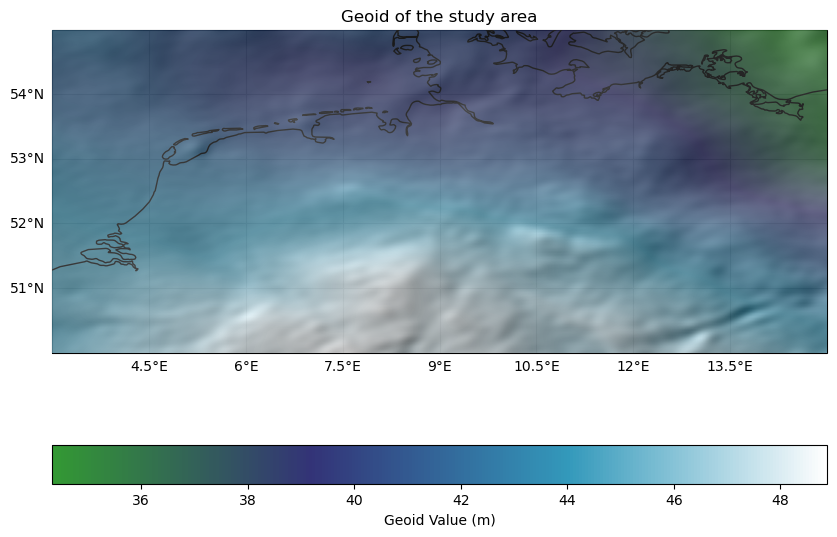

In [17]:
#read geoid
with rasterio.open(geoid_path) as src:
    # Read the geoid data as a numpy array
    geoid_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(geoid_array, 330, 30)

#get the extent of the geoid
with rasterio.open(geoid_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.coastlines(zorder= 10)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot geoid
cax = ax.imshow(geoid_array, cmap='ocean', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Geoid Value (m)', orientation='horizontal')
plt.title('Geoid of the study area')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Digital Elevation Model and Bedrock Elevation


 All ETOPO tiles are in horizontal WGS84 geographic coordinates (EPSG:4326) and referenced in meters relative to the Earth Gravitational Model of 2008 (EGM2008) geoid surface (EPSG:3855). Each tile comes with an accompanying “geoid” tile for converting EGM2008 geoid heights into WGS84 ellipsoid elevation heights (EPSG:4979). 

**Elevation Conversion**

To convert a given tile from EGM2008 to WGS84-referenced elevations, we need to add the values of the elevation tile to the geoid-height tile:

   **ETOPO Elevation (EGM2008) + GEOID = WGS84 Elevation**

https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO2022/docs/1.2%20ETOPO%202022%20User%20Guide.pdf, 7/8/2023

Therefore, to compute the elevation model, the bedrock elevation needs to be added to the Geoid. Bedrock elevation of the study area is obtained from the ETOPO 2022 Bedrock model with 15 arcsecond resolution and is Extracted from the Grid Extractor function for bounding box as Geotiff files. https://www.ncei.noaa.gov/maps/grid-extract/ 7/1/2023


## Bedrock Elevation

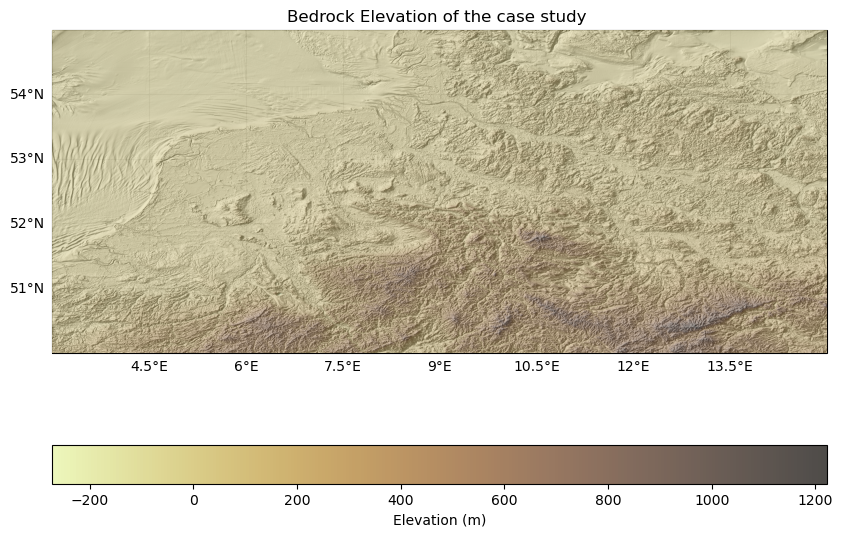

In [29]:
#bedrock directory
bedrock_path = '/home/sahar/SLR_Bonn_Polimi/Data/ETOPO/Europe_Bedrock_15arcsec.tiff'

#read bedrock
with rasterio.open(bedrock_path) as src:
    # Read the bedrock data as a numpy array
    bedrock_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(bedrock_array, 330, 30)

#get the extent of the bedrock
with rasterio.open(bedrock_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
#ax.coastlines(zorder= 15)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot bedrock
cax = ax.imshow(bedrock_array, cmap=cmocean.cm.turbid, extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Elevation (m)', orientation='horizontal')
plt.title('Bedrock Elevation of the case study ')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

In order to Calculate the DEM, having Geoid and Bedrock Elevation, in QGIS software these two geotif files are added together using Raster Calculator. 

**DEM (WGS84) = Bedrock Elevation + Geoid**

## Computation Pre-requisite
Before raster calculation in gdal we need to make sure that all inputs have the same resolution, coordinate reference system, and extent; otherwise reprojection and resampling are required. For this checkup we use **GetGeoTransform** function and **GetProjection** function of Gdal library. Following we see the result for Bedrock and Geoid datasets.

### Checking Bedrock Dataset

In [30]:
#checking the resolution and Geographical coordinate system of the Bedrock
Bedrock = gdal.Open(bedrock_path)
#get the geotransform
bed_geotrns= Bedrock.GetGeoTransform()
print ('Bedrock resolution in X is ', bed_geotrns[1],' and in Y is ', bed_geotrns[-1],'. Bedrock minimum longitude is ', bed_geotrns[0],' and maximum latituude is ',bed_geotrns[3])
#get the projection
bed_geoprj = Bedrock.GetProjection()
print('Bedrock projection information:', bed_geoprj)

Bedrock resolution in X is  0.004166666666666667  and in Y is  -0.004166666666666667 . Bedrock minimum longitude is  3.0  and maximum latituude is  55.0
Bedrock projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Bedrock has 0.00417 degree resolution and Geographical Coordinate Reference System on WGS84 ellipsoid.

### Checking Geoid Dataset

In [31]:
#checking the resolution and Geographical coordinate system of the Geoid
Geoid = gdal.Open(geoid_path)
#get the geotransform
geoid_geotrns= Geoid.GetGeoTransform()
print ('Geoid resolution in X is ', geoid_geotrns[1],' and in Y is ', geoid_geotrns[-1],'. Geoid minimum longitude is ', geoid_geotrns[0],' and maximum latituude is ',geoid_geotrns[3])
#get the projection
geoid_geoprj = Geoid.GetProjection()
print('Geoid projection information:', geoid_geoprj)

Geoid resolution in X is  0.004166666666666667  and in Y is  -0.004166666666666667 . Geoid minimum longitude is  3.0  and maximum latituude is  55.0
Geoid projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Geoid has 0.00417 degree resolution and Geographical Coordinate Reference System on WGS84 ellipsoid.

The Geoid and Bedrock dataset of the study area have the same extent, the resolutio and coordinate system. Therefore, no modification in input dataset is needed for DEM calculation. To do so, we only need to sum the Geoid and Bedrock datasets. The compution is performed using **calc.py** function of the Gdal library.

### Computing Digital Elevation Model

In [32]:
#raster calculation using gdal
!gdal_calc.py -A /home/sahar/SLR_Bonn_Polimi/output_tif/EU_bbox_Geoid_15s.tif -B /home/sahar/SLR_Bonn_Polimi/Data/ETOPO/Europe_Bedrock_15arcsec.tiff --calc="A+B" --outfile=/home/sahar/SLR_Bonn_Polimi/output_tif/EU_DEM.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


### Visualizing Digital Elevation Model
To visulize the computed DEM, we use Rasterio and Cartopy Libraries.

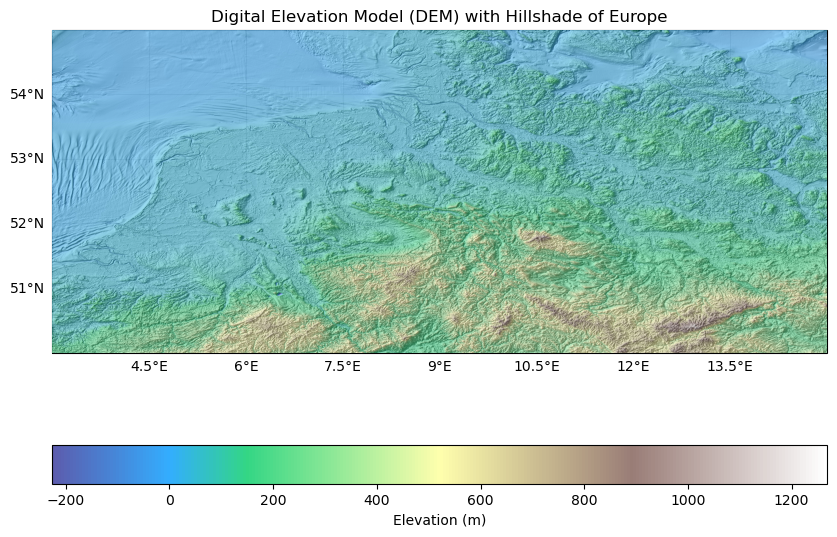

In [33]:
#DEM directory
dem_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/EU_DEM.tif'

#read DEM
with rasterio.open(dem_path) as src:
    # Read the DEM data as a numpy array
    dem_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(dem_array, 330, 30)


#get the extent f the DEM
with rasterio.open(dem_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
#ax.coastlines(zorder= 10)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot DEM
cax = ax.imshow(dem_array, cmap= 'terrain', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)#GMT colormaps instead could be used
plt.colorbar(cax, label='Elevation (m)', orientation='horizontal')
plt.title('Digital Elevation Model (DEM) with Hillshade of Europe')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Mean Sea Surface
The mean sea surface is the displacement of the sea surface relative to a mathematical model of the earth and it closely follows the geoid. Amplitudes ranges between +/- 100 meters. https://www.space.dtu.dk/english/research/scientific_data_and_models/global_mean_sea_surface 7/17/2023. The DTU15MSS is the latest release of the global high resolution mean sea surface from DTU Space. Therefore for this research the netcdf dataset of DT15MSS with 1 min resolution is used as the Mean Sea Surface https://ftp.space.dtu.dk/pub/DTU15/1_MIN/ 7/17/2023. The dataset then converted to Geotif in QGIS software.
In the next step, global MSS is clipped for the study area bounding box using gdal library.


## Clipping Mean Sea Surface for the study area

In [34]:
#open Global MSS in gdal
ds = gdal.Open("/home/sahar/SLR_Bonn_Polimi/Data/DTU/DTU15MSS_1min.tiff")
#output direcory
EU_MSS_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/Europe_MSS.tif'
#clip for bbox
dsClip = gdal.Warp(EU_MSS_path, ds, cutlineDSName= area_bbox, cropToCutline = True,
                  dstNodata = np.nan)
array = dsClip.GetRasterBand(1).ReadAsArray()
ds_Clip = None

## Visualizing the Mean Sea Surface

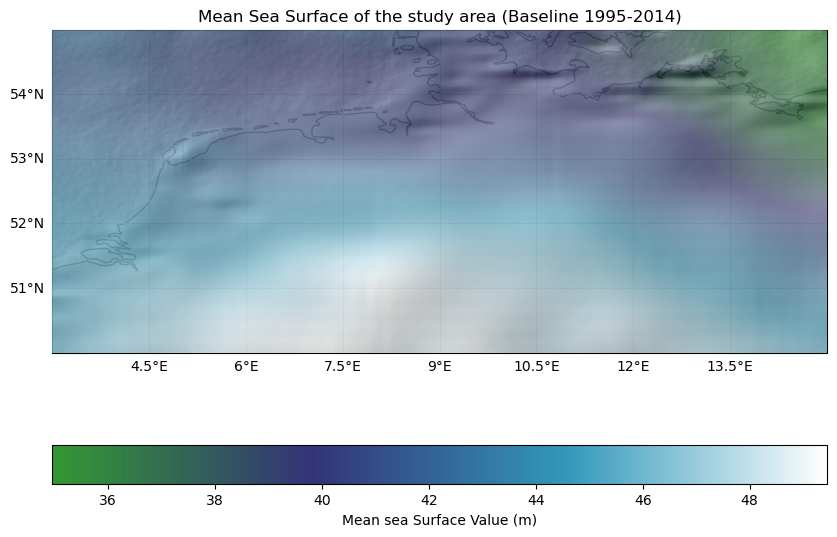

In [35]:
#read mean sea surface in rasterio
with rasterio.open(EU_MSS_path) as src:
    #read the mean sea surface data as a numpy array
    mss_array = src.read(1)

#hillshade function for better visualization of Elevation
def hillshade(array, azimuth, angle_altitude):
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth * np.pi / 180.
    altituderad = angle_altitude * np.pi / 180.
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(slope) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2

#compute the hillshade
hillshade_array = hillshade(mss_array, 330, 30)

#get the extent of the mean sea surface
with rasterio.open(EU_MSS_path) as src:
    xmin, ymin, xmax, ymax = src.bounds

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=projection)
ax.add_feature(cfeature.COASTLINE)
#plot hillshade
ax.imshow(hillshade_array, cmap='gray', extent=[xmin, xmax, ymin, ymax], alpha=0.5, zorder=10)
#plot mean sea surface
cax = ax.imshow(mss_array, cmap='ocean', extent=[xmin, xmax, ymin, ymax], alpha=0.8, zorder=5)
plt.colorbar(cax, label='Mean sea Surface Value (m)', orientation='horizontal')
plt.title('Mean Sea Surface of the study area (Baseline 1995-2014)')

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.show()

# Computation pre-requirements
In order to do computation between the ratser layers they must have some similar features. They need to be in a same coordinate reference system, have the same extent (otherwise the map with smallest extent will be considered as the extent reference) and same geographical resolution. The resolution of the computation output could be defined before hand. Here, to have the most acurate simulation, the resolution of the data with highest resolution is referenced which is ETOPO Bedrock and Geoid with 15 arc seconds resolution. First of all, we check the GeoTransform and GeoProjection of the input datasets using Gdal library.

### For Mean Sea Surface

In [36]:
#checking the resolution and Geographical coordinate system of the MSS
MSS = gdal.Open(EU_MSS_path)
#get the geotransform
MSS_geotrns= MSS.GetGeoTransform()
print ('MSS resolution in X is ', MSS_geotrns[1],' and in Y is ', MSS_geotrns[-1],'. MSS minimum longitude is ', MSS_geotrns[0],' and maximum latituude is ',MSS_geotrns[3])
#get the projection
MSS_geoprj = MSS.GetProjection()
print('MSS projection information:' , MSS_geoprj)

MSS resolution in X is  0.016666666666697527  and in Y is  -0.016666666666666666 . MSS minimum longitude is  2.9999999996722524  and maximum latituude is  55.0
MSS projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


### For DEM

In [37]:
#checking the resolution and Geographical coordinate system of the DEM
DEM = gdal.Open(dem_path)
#get the geotransform
DEM_geotrns= DEM.GetGeoTransform()
print ('DEM resolution in X is ', DEM_geotrns[1],' and in Y is ', DEM_geotrns[-1],'. DEM minimum longitude is ', DEM_geotrns[0],' and maximum latituude is ',DEM_geotrns[3])
#get the projection
DEM_geoprj = DEM.GetProjection()
print('DEM projection information:', DEM_geoprj)
#DEM = None

DEM resolution in X is  0.004166666666666667  and in Y is  -0.004166666666666667 . DEM minimum longitude is  3.0  and maximum latituude is  55.0
DEM projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


### For Sea Level Change 2020

In [38]:
#checking the resolution and Geographical coordinate system of the IPCC
#EU_IPCC_SLC_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/EU_IPCC_SLC_2020_SSP245.tif'
IPCC = gdal.Open(EU_IPCC_SLC_path)
#get the geotransform
IPCC_geotrns= IPCC.GetGeoTransform()
print ('IPCC resolution in X is ', IPCC_geotrns[1],' and in Y is ', IPCC_geotrns[-1],'. IPCC minimum longitude is ', IPCC_geotrns[0],' and maximum latituude is ',IPCC_geotrns[3])
#get the projection
IPCC_geoprj = IPCC.GetProjection()
print('IPCC SLC2020 projection information:', IPCC_geoprj)
#IPCC = None

IPCC resolution in X is  1.0  and in Y is  -1.0 . IPCC minimum longitude is  3.0  and maximum latituude is  55.0
IPCC SLC2020 projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


### For Annual trend

In [39]:
#checking the resolution and Geographical coordinate system of the TRND
TRND = gdal.Open(EU_trend)
#get the geotransform
TRND_geotrns= TRND.GetGeoTransform()
print ('TRND resolution in X is ', TRND_geotrns[1],' and in Y is ', TRND_geotrns[-1],'. TRND minimum longitude is ', TRND_geotrns[0],' and maximum latituude is ',TRND_geotrns[3])
#get the projection
TRND_geoprj = TRND.GetProjection()
print('trend projection information:', TRND_geoprj)
#TRND = None

TRND resolution in X is  0.25  and in Y is  -0.25 . TRND minimum longitude is  3.0  and maximum latituude is  55.0
trend projection information: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


As shown in the outputs of GetGeoTransform and GetProjection functions, all datasets have same Coordinate Reference Systems and the same extent (same as the bounding box). But, they have different resolution. Therefore, resampling is required.

## Resampling the inputs

For doing the computation between the inputs and having the highest possible resolution, we resample all the input datasets with the highest resolution of the inputs. In this case, the highest resolution is 15 arcsec corresponds to the DEM. Therefore, other inputs including MSS, IPCC2020, TRND need to be resampled with the resolution of DEM.

The resampling is performed by **Warp** function of Gdal library.

In [40]:
#highst resolution among the datasets
res = min(MSS_geotrns[1], DEM_geotrns[1], IPCC_geotrns[1], TRND_geotrns[1])
# resample input datasets
MSSres = gdal.Warp('/home/sahar/SLR_Bonn_Polimi/output_tif/EU_MSSres.tif', MSS, xRes = res, yRes = res, resampleAlg = "bilinear")
IPCCres = gdal.Warp('/home/sahar/SLR_Bonn_Polimi/output_tif/EU_IPCCres.tif', IPCC, xRes = res, yRes = res, resampleAlg = "bilinear")
TRNDres = gdal.Warp('/home/sahar/SLR_Bonn_Polimi/output_tif/EU_TRNDres.tif', TRND, xRes = res, yRes = res, resampleAlg = "bilinear")

#checking the resolution of the resamples datasets
print('Resolution of the Resampled Mean Sea Sufrace is', MSSres.GetGeoTransform()[1])
print('Resolution of the Resampled IPCC sea level change 2020 is ', IPCCres.GetGeoTransform()[1])
print('Resolution of the Resampled annual Trend of sea level change is', TRNDres.GetGeoTransform()[1])
print('Resolution of the DEM is', DEM.GetGeoTransform()[1])

#closing the datasets
MSSres = IPCCres = TRNDres = None


Resolution of the Resampled Mean Sea Sufrace is 0.004166666666666667
Resolution of the Resampled IPCC sea level change 2020 is  0.004166666666666667
Resolution of the Resampled annual Trend of sea level change is 0.004166666666666667
Resolution of the DEM is 0.004166666666666667


Now that all inputs have the same extent and the same resolution, we can do the computation on them.

# Computation of the Future Sea Level Height

To predict future sea level heights based on the annual trend of sea level rise, we rely on establishing a reference point for this trend. This reference point is defined as the projected sea level for a designated base year (2020), as stipulated by the IPCC. The computation of this base reference involves the addition of the Mean Sea Surface value to the projected sea level change as estimated by the IPCC for the year 2020. Subsequently, for any given year, the sea level height is calculated by augmenting the base reference with the product of the difference between that year and 2020, and the annual trend value. In essence, the sea level height for the year denoted as 'N' can be expressed as:

**SLH_N = MSS + IPCC2020 + (N - 2020) x TRND**

This computational process is facilitated through the utilization of the Gdal tool. To illustrate, provided below is a script exemplifying the computation of sea level height for the year 2100.

In [41]:
#calculating the sea level height for the year 2100
!gdal_calc.py -A /home/sahar/output_tif/EU_MSSres.tif -B /home/sahar/SLR_Bonn_Polimi/output_tif/EU_IPCCres.tif -C /home/sahar/SLR_Bonn_Polimi/output_tif/EU_TRNDres.tif --calc="A+B+(80*C)" --outfile=/home/sahar/SLR_Bonn_Polimi/output_tif/EU_SLH_2100.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In this context, the computation (A + B + 80*C) serves to project the anticipated sea level height for the year 2100. This computation involves the summation of two components: the sea level measurements at the base year 2020 (A + B), and the accumulation of sea level alterations over the span of 80 years (80xC) between 2020 and 2100.

The same procedural approach is applied uniformly across the range of years from 2020 to 2100. To execute this, a designated output directory labeled as "sea_level_maps" is established. This directory encompasses the collection of projected sea level heights for every individual year within the aforementioned period. Subsequently, the process entails the implementation of gdal raster calculations, which are executed iteratively through a loop spanning from 2020 to 2100.

In [ ]:
#calculating the sea level height for the all years between 2020 to 2100
# Input file paths
sea_level_2020_file = "/home/sahar/SLR_Bonn_Polimi/output_tif/EU_MSSres.tif"
ipcc_correction_file = "/home/sahar/SLR_Bonn_Polimi/output_tif/EU_IPCCres.tif"
annual_trend_file = "/home/sahar/SLR_Bonn_Polimi/output_tif/EU_TRNDres.tif"

# Output directory for sea level maps
SLH_directory = "/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/"

# Years range (inclusive)
start_year = 2020
end_year = 2100

# Loop through each year and calculate sea level
for year in range(start_year, end_year + 1):
    output_file = SLH_directory + f"EU_SLH_{year}.tif"
    calculation_expression = f"A + B + {year - start_year} * C"
    
    # Construct gdal_calc command
    gdal_calc_cmd = [
        "gdal_calc.py",
        "-A", sea_level_2020_file,
        "-B", ipcc_correction_file,
        "-C", annual_trend_file,
        "--calc", calculation_expression,
        "--outfile", output_file
    ]
    
    # Execute gdal_calc command
    subprocess.run(gdal_calc_cmd)

print("Sea level maps calculation completed.")


As an illustrative demonstration, we present visualizations of sea level heights for four arbitrarily chosen years. 

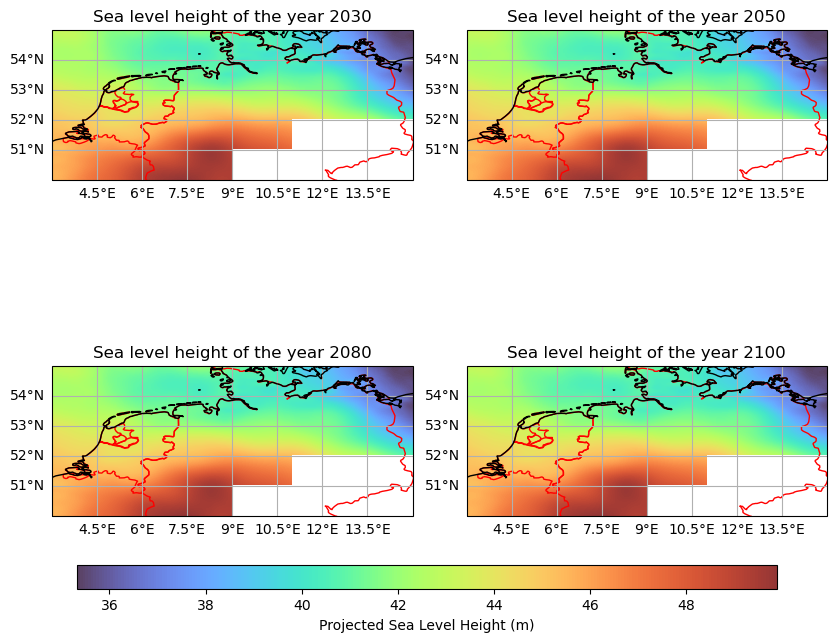

In [43]:
# plot sea level height for some random years
#define the directory for sea level height maps

dir_SLH = {
    'Sea level height of the year 2030': '/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/EU_SLH_2030.tif',
    'Sea level height of the year 2050': '/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/EU_SLH_2050.tif',
    'Sea level height of the year 2080': '/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/EU_SLH_2080.tif',
    'Sea level height of the year 2100': '/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/EU_SLH_2100.tif',
}

# define the common projection
projection = ccrs.PlateCarree()

#create a figure with subplots using GridSpec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], wspace=0.15, hspace=0.2)

#loop through the directory and plot each sea level height map
for i, (title, file_path) in enumerate(dir_SLH.items()):
    with rasterio.open(file_path) as src:
        SLH_array = src.read(1)
        xmin, ymin, xmax, ymax = src.bounds

    ax = plt.subplot(gs[i], projection=projection)
    ax.coastlines(zorder=10)
    cax = ax.imshow(SLH_array, cmap='turbo', extent=[xmin, xmax, ymin, ymax], alpha=0.8)
    ax.set_title(title)
    #adding the country administrative boundries to the plot
    shapefile = gpd.read_file(area_adm_path)
    #create geodataframe out of the shapefile of boundries
    gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])
    #Add the area-adm to the plot
    ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False

#add a colorbar and title for the entire figure
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Projected Sea Level Height (m)')
plt.tight_layout()

# Show the plots
plt.show()


# Creating Flood Maps
By possessing the sea level height data for the respective years and integrating it with the topography of the study area, we gain the capability to delineate areas that might be subject to flooding. This task is efficiently performed using the calculator function (calc.py) of the Gdal library. This entails identifying all pixels with elevations lower than the corresponding sea level height. For instance, considering the year 'N', the region prone to inundation can be defined as:

**Flood = where (SLH_N <= DEM)**

To provide a concrete example, the following script outlines the procedural steps for calculating the flooded area specifically for the year 2100.

In [44]:
#calculating the flood for the year 2100
!gdal_calc.py -A /home/sahar/SLR_Bonn_Polimi/output_tif/EU_DEM.tif -B /home/sahar/SLR_Bonn_Polimi/output_tif/EU_SLH_2100.tif --outfile=/home/sahar/output_tif/EU_flood_2100.tif --calc="A <= B"


0...10...20...30...40...50...60...70...80...90...100 - done.


For the computation of flood maps spanning from 2020 to 2100, we can extend the prior script to encompass a looping mechanism that iterates through each individual year. This iterative process involves utilizing the gdal_calc.py command to calculate the flooded areas. The outcomes of these calculations are systematically stored within a designated directory named "flood_maps." This comprehensive approach ensures that flood maps are generated for each respective year, effectively capturing the evolving inundation patterns over the entire time range.

In [ ]:
#calculating the flooded area for the all years between 2020 to 2100
#input file paths
flood_directory = "/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps/"

# years range (inclusive)
start_year = 2020
end_year = 2100

#loop through each year and calculate flood map
for year in range(start_year, end_year + 1):
    sea_level_file = f"/home/sahar/SLR_Bonn_Polimi/output_tif/sea_level_maps/EU_SLH_{year}.tif"
    output_file = flood_directory + f"EU_flood_{year}.tif"
    
    # construct gdal_calc command
    gdal_calc_cmd = [
        "gdal_calc.py",
        "-A", dem_path,
        "-B", sea_level_file,
        "--outfile", output_file,
        "--calc", "A <= B"
    ]
    
    #execute gdal_calc command
    subprocess.run(gdal_calc_cmd)

print("Flood maps calculation completed.")


Here as some examples, the simulated flood map for 4 arbitrary years are visulized.

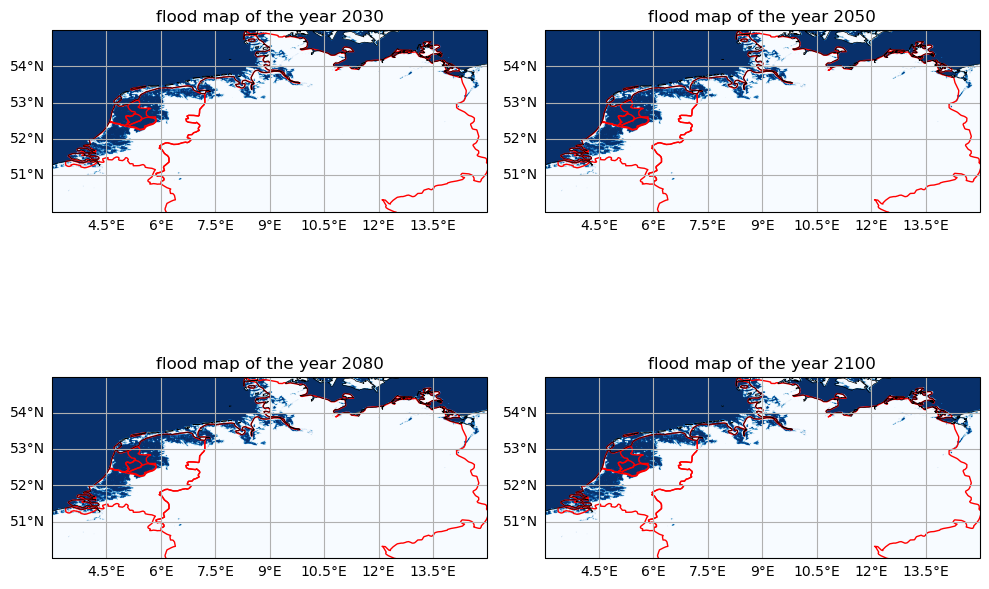

In [46]:
#plotting sample flood maps 
#list of the flood maps
dir_floods = {
    'flood map of the year 2030': '/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps/EU_flood_2030.tif',
    'flood map of the year 2050': '/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps/EU_flood_2050.tif',
    'flood map of the year 2080': '/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps/EU_flood_2080.tif',
    'flood map of the year 2100': '/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps/EU_flood_2100.tif',
}

crs = ccrs.PlateCarree()
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': crs})

for ax, (title, file_path) in zip(axs.flat, dir_floods.items()):
    with rasterio.open(file_path) as src:
        flood_map = src.read(1)
        transform = src.transform
        bounds = src.bounds

    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    im = ax.imshow(flood_map, extent=extent, cmap='Blues', vmin=0, vmax=1, origin='upper', transform=crs)
    
    ax.set_title(title)
    #adding the country administrative boundries to the plot
    shapefile = gpd.read_file(area_adm_path)
    #create geodataframe out of the shapefile of boundries
    gdf = gpd.GeoDataFrame(geometry=shapefile["geometry"])
    #Add the area-adm to the plot
    ax.add_geometries(gdf["geometry"], crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    ax.coastlines(resolution='10m', color='black', linewidth=0.5)

plt.tight_layout()
plt.show()
